# **BST260 Project**

In [58]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from torch.utils.data import DataLoader, Dataset
np.random.seed(42)

In [59]:
cd drive/MyDrive/harvard/bst260/

[Errno 2] No such file or directory: 'drive/MyDrive/harvard/bst260/'
/content/drive/MyDrive/harvard/bst260


In [60]:
dat = pd.read_csv('bone-marrow.csv')
dat

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1,1,22.830137,0,1,0,1,1,1,0,...,1,7.20,1.33876,5.38,35,19,51,32,999,0
1,1,0,23.342466,0,1,0,-1,-1,1,0,...,1,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
2,1,0,26.394521,0,1,0,-1,-1,1,0,...,1,7.94,19.01323,0.42,23.4,23,20,1000000,435,1
3,0,0,39.684932,1,1,0,1,2,1,1,...,?,4.25,29.481647,0.14,50,23,29,19,53,1
4,0,1,33.358904,0,0,0,1,2,0,1,...,1,51.85,3.972255,13.05,9,14,14,1000000,2043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1,0,0,...,1,11.08,2.52275,4.39,44,15,22,16,385,1
183,0,1,22.895890,0,0,0,1,0,1,1,...,1,4.64,1.038858,4.47,44.5,12,30,1000000,634,1
184,0,1,27.347945,0,1,0,1,-1,1,1,...,1,7.73,1.635559,4.73,33,16,16,1000000,1895,0
185,1,1,27.780822,0,1,0,1,0,1,1,...,0,15.41,8.07777,1.91,24,13,14,54,382,1


In [61]:
dat['survival_status'].sum()/dat.shape[0]

0.45454545454545453

From above we can see that in terms of outcome status, our dataset is actually relatively balanced. And so, we may be able to proceed without sampling corrections.

### **Investigating Correlation Structure**

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

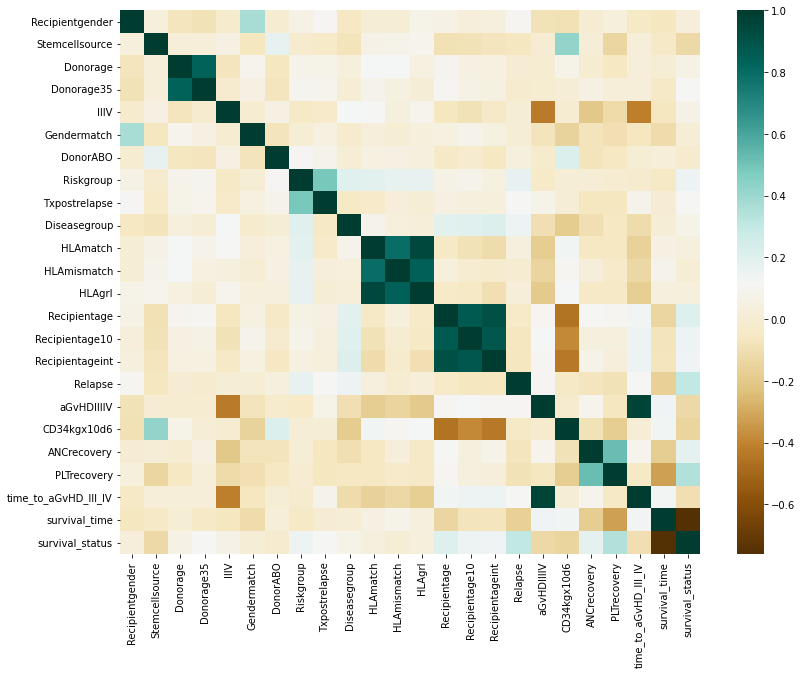

In [63]:
plt.figure(figsize = (13, 10))
sns.heatmap(dat.corr(), cmap = 'BrBG')

Survival status seems to be correlated with Relapse, PLTrecovery. Survival time seems to not be very strongly correlated with any variables, although mildly correlated with Recipientage and Relapse. Overall, we don't have *a lot* of multicollinearity but we do have some, for example the *HLA* variables are highly correlated and the *Recipientage* variables are also highly correlated. Many of the other variables have a slight negative correlation. Overall, it might help to perform a PCA to help decorrelate some variables during our predictive modeling. 

We will remove *survival_time* and *survival_status* for those individual outcome models as they are extremely correlated with each other. This makes sense as if you survive long enough past follow-up then you will not count as a death outcome.

### **Missing Data and Non-Numerics**

Let's make sure the data is in numerical format.

In [64]:
dat.apply(pd.to_numeric, errors='coerce').isnull().sum()


Recipientgender           0
Stemcellsource            0
Donorage                  0
Donorage35                0
IIIV                      0
Gendermatch               0
DonorABO                  0
RecipientABO              1
RecipientRh               2
ABOmatch                  1
CMVstatus                16
DonorCMV                  2
RecipientCMV             14
Disease                 187
Riskgroup                 0
Txpostrelapse             0
Diseasegroup              0
HLAmatch                  0
HLAmismatch               0
Antigen                   1
Alel                      1
HLAgrI                    0
Recipientage              0
Recipientage10            0
Recipientageint           0
Relapse                   0
aGvHDIIIIV                0
extcGvHD                 31
CD34kgx10d6               0
CD3dCD34                  5
CD3dkgx10d8               5
Rbodymass                 2
ANCrecovery               0
PLTrecovery               0
time_to_aGvHD_III_IV      0
survival_time       

We see some non-numeric data!

In [65]:
set(dat['RecipientCMV'])

{'0', '1', '?'}

In [66]:
set(dat['RecipientRh'])

{'0', '1', '?'}

In [67]:
set(dat['ABOmatch'])

{'0', '1', '?'}

In [68]:
set(dat['CMVstatus'])

{'0', '1', '2', '3', '?'}

In [69]:
set(dat['DonorCMV'])

{'0', '1', '?'}

In [70]:
set(dat['RecipientCMV'])

{'0', '1', '?'}

In [71]:
set(dat['Disease'])

{'ALL', 'AML', 'chronic', 'lymphoma', 'nonmalignant'}

In [72]:
set(dat['Antigen'])

{'-1', '0', '1', '2', '?'}

In [73]:
set(dat['Alel'])

{'-1', '0', '1', '2', '3', '?'}

In [74]:
set(dat['extcGvHD'])

{'0', '1', '?'}

We have a small proportion of missing data, so something we might want to try is comparing complete case analyses with an imputation technique like MICE.

In [75]:
# first we should get numerical structure
dat = pd.concat([
    dat, 
    pd.get_dummies(dat['Disease'])
    ], 
    axis = 1).drop(['Disease'], axis = 1)
dat = dat.apply(pd.to_numeric, errors='coerce')
dat

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status,ALL,AML,chronic,lymphoma,nonmalignant
0,1,1,22.830137,0,1,0,1,1.0,1.0,0.0,...,19,51,32,999,0,1,0,0,0,0
1,1,0,23.342466,0,1,0,-1,-1.0,1.0,0.0,...,16,37,1000000,163,1,1,0,0,0,0
2,1,0,26.394521,0,1,0,-1,-1.0,1.0,0.0,...,23,20,1000000,435,1,1,0,0,0,0
3,0,0,39.684932,1,1,0,1,2.0,1.0,1.0,...,23,29,19,53,1,0,1,0,0,0
4,0,1,33.358904,0,0,0,1,2.0,0.0,1.0,...,14,14,1000000,2043,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,1,1,37.575342,1,1,0,1,1.0,0.0,0.0,...,15,22,16,385,1,0,0,0,1,0
183,0,1,22.895890,0,0,0,1,0.0,1.0,1.0,...,12,30,1000000,634,1,0,1,0,0,0
184,0,1,27.347945,0,1,0,1,-1.0,1.0,1.0,...,16,16,1000000,1895,0,0,0,0,0,1
185,1,1,27.780822,0,1,0,1,0.0,1.0,1.0,...,13,14,54,382,1,0,0,1,0,0


## **Imputation**

In [76]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

X = dat.drop(['survival_time', 'survival_status'], axis = 1)


Death = dat['survival_status']
STime = dat['survival_time']

mulpute = IterativeImputer(max_iter=10, random_state=0, verbose = 2).fit(X)
X_mp = mulpute.transform(X)

missing_idx = [x[1] for x in list(dat.unstack()[dat.isnull().unstack()].index)]
X_cc = dat.drop(index=missing_idx)
Death_cc = X_cc['survival_status']
STime_cc = X_cc['survival_time']
X_cc = X_cc.drop(['survival_time', 'survival_status'], axis = 1)

[IterativeImputer] Completing matrix with shape (187, 39)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.12
[IterativeImputer] Change: 143.5886936385968, scaled tolerance: 1000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (187, 39)
[IterativeImputer] Ending imputation round 1/1, elapsed time 0.00


First, we'll split an 80/20 train-test in order to work with both the MICE and complete case training set.

In [77]:
trainX_mp, testX_mp, \
    trainDeath_mp, testDeath_mp, \
    trainSTime_mp, testSTime_mp = train_test_split(
             X_mp, 
             Death, 
             STime,
             test_size = 0.2
)
    
trainX_cc, testX_cc, \
    trainDeath_cc, testDeath_cc, \
    trainSTime_cc, testSTime_cc = train_test_split(
             X_cc, 
             Death_cc, 
             STime_cc,
             test_size = 0.2
)

In [78]:
p = trainX_mp.shape[1]

print(f"MICE Training shape: {trainX_mp.shape, trainDeath_mp.shape}")
print(f"MICE Testing shape: {testX_mp.shape, testDeath_mp.shape}")

MICE Training shape: ((149, 39), (149,))
MICE Testing shape: ((38, 39), (38,))


## **PCA**

#### **For MICE**

Text(0, 0.5, 'Explained Variance')

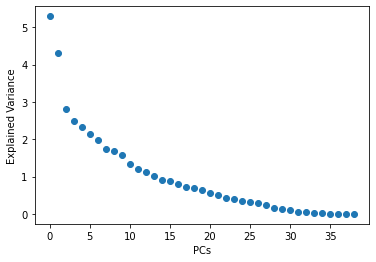

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Standardize rows to training set
stdizer = StandardScaler().fit(trainX_mp)
trainX_std = stdizer.transform(trainX_mp) # trainX_std.sum(axis = 0) = 0 down columns
testX_std = stdizer.transform(testX_mp) # standardize using trainX

# 1. PCA
pca = PCA(n_components = p).fit(trainX_std)
trainX_pca = pca.transform(trainX_std)
plt.scatter(range(p), pca.explained_variance_)
plt.xlabel("PCs")
plt.ylabel("Explained Variance")

#### **For Complete Cases**

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Text(0, 0.5, 'Explained Variance')

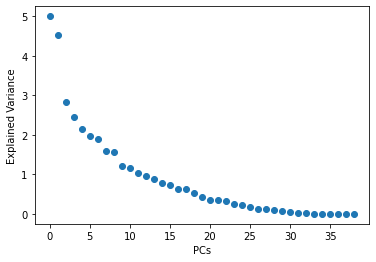

In [80]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Standardize rows to training set
stdizer_cc = StandardScaler().fit(trainX_cc)
trainX_stdcc = stdizer.transform(trainX_cc) # trainX_std.sum(axis = 0) = 0 down columns
testX_stdcc = stdizer.transform(testX_cc) # standardize using trainX

# 1. PCA
pca_cc = PCA(n_components = p).fit(trainX_stdcc)
trainX_pcacc = pca.transform(trainX_stdcc)
plt.scatter(range(p), pca_cc.explained_variance_)
plt.xlabel("PCs")
plt.ylabel("Explained Variance")

In both cases, it might suffice to use $\approx$ 30 PCs as predictors as this seems to be when the elbow occurs, that not much more variance is explained by the PCs. Furthermore, because we do not see a large amount of low explained variances, we will opt to use all features (non-transformed) in our prediction models.

# **Predicting Survival Status**

### **An Initial Logistic Model**

First, let's check whether imputation helps out prediction at all.

In [81]:
from sklearn.linear_model import LogisticRegressionCV
logreg_mp = LogisticRegressionCV(cv= 5, random_state = 0)
logreg_mp.fit(trainX_mp, trainDeath_mp)
y_pred_mp = logreg_mp.predict(testX_mp) 

MICE F1 Score: 0.38461538461538464
MICE AUC Score: 0.5535714285714286
MICE ACC Score: 0.5789473684210527
MICE Confusion Matrix:
 [[0.60714286 0.39285714]
 [0.5        0.5       ]]


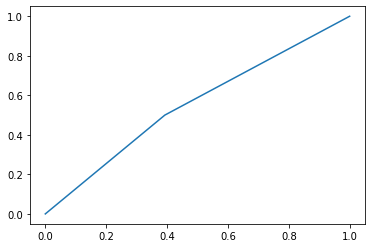

In [82]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
print(f"MICE F1 Score: {f1_score(y_pred_mp, testDeath_mp)}")
print(f"MICE AUC Score: {roc_auc_score(y_pred_mp, testDeath_mp)}")
print(f"MICE ACC Score: {accuracy_score(y_pred_mp, testDeath_mp)}")
print(f"MICE Confusion Matrix:\n {confusion_matrix(y_pred_mp, testDeath_mp, normalize = 'true')}")
tpr_mp, fpr_mp, threshold_mp = roc_curve(y_pred_mp, testDeath_mp)
plt.plot(tpr_mp, fpr_mp)


Here we have relatively equal true negative and true positive rate. The auc of 0.69 is not great, however. How about the complete case analysis?

In [83]:
logreg_cc = LogisticRegressionCV(cv= 5, random_state = 0)
logreg_cc.fit(trainX_cc, trainDeath_cc)
y_pred_cc = logreg_mp.predict(testX_cc) 

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegressionCV was fitted without feature names
  warnings.warn(


CC F1 Score: 0.3
CC AUC Score: 0.48701298701298695
CC ACC Score: 0.5172413793103449
CC Confusion Matrix:
 [[0.54545455 0.45454545]
 [0.57142857 0.42857143]]


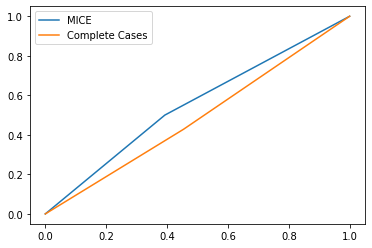

In [84]:
print(f"CC F1 Score: {f1_score(y_pred_cc, testDeath_cc)}")
print(f"CC AUC Score: {roc_auc_score(y_pred_cc, testDeath_cc)}")
print(f"CC ACC Score: {accuracy_score(y_pred_cc, testDeath_cc)}")
print(f"CC Confusion Matrix:\n {confusion_matrix(y_pred_cc, testDeath_cc, normalize = 'true')}")

plt.plot(tpr_mp, fpr_mp, label = 'MICE')

tpr_cc, fpr_cc, threshold_cc = roc_curve(y_pred_cc, testDeath_cc)
plt.plot(tpr_cc, fpr_cc, label = 'Complete Cases')
plt.legend()


Here, we notice that the multiple imputed dataset is performing a bit better than the complete cases. For future modeling, we will just use the MICE imputed dataset. Overall, the logistic regression model only seems to get around 60% accuracy and 44.4% F1 suggesting potentially poor discriminative ability. We will next try using some non-parametric models like gradient-boosted classification trees in order to try and get a better predictive result. 

### **Can we improve this with XGBoost?**

In [ ]:
# hyperparameter tuning
params = {'n_estimators':[150, 250, 350], 
         'max_depth':[3, 6, 10],  # XGB complexity
         'min_child_weight':[1, 6], # min sum of obs req in a child
         'learning_rate':[0.2, 0.3], # step size shrinkage
         'gamma':[1], # complexity penalty term
         'subsample':[0.5, 1], # subsample for each tree
         'objective':['binary:logistic']}

xgb_gs = xgb.XGBClassifier(seed = 0, tree_method='gpu_hist')
gs = GridSearchCV(xgb_gs, params, 
                  cv = 5, verbose = 3)
gs.fit(trainX_mp, trainDeath_mp)

In [86]:
gs.best_params_

{'gamma': 1,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 250,
 'objective': 'binary:logistic',
 'subsample': 1}

In [87]:
best_params = {'gamma': 1,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 250,
 'objective': 'binary:logistic',
 'subsample': 1}

xgb_c = xgb.XGBClassifier(**best_params, seed = 0, tree_method='gpu_hist')
xgb_c.fit(trainX_mp, trainDeath_mp)
y_pred = xgb_c.predict(testX_mp)

CC F1 Score: 0.6875
CC AUC Score: 0.7301136363636364
CC ACC Score: 0.7368421052631579
CC Confusion Matrix:
 [[0.77272727 0.22727273]
 [0.3125     0.6875    ]]


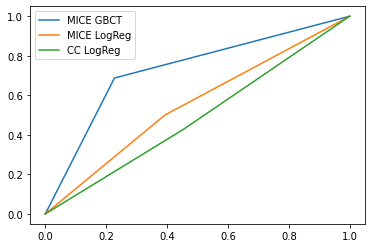

In [88]:
print(f"CC F1 Score: {f1_score(y_pred, testDeath_mp)}")
print(f"CC AUC Score: {roc_auc_score(y_pred, testDeath_mp)}")
print(f"CC ACC Score: {accuracy_score(y_pred, testDeath_mp)}")
print(f"CC Confusion Matrix:\n {confusion_matrix(y_pred, testDeath_mp, normalize = 'true')}")

tpr, fpr, threshold = roc_curve(y_pred, testDeath_mp)
plt.plot(tpr, fpr, label = 'MICE GBCT')
plt.plot(tpr_mp, fpr_mp, label = 'MICE LogReg')
plt.plot(tpr_cc, fpr_cc, label = 'CC LogReg')
plt.legend()

Although not the perfect classifier, notice that the gradient-boosted classification tree outperforms both logistic regression models by a large margin. Let's see what contributed to this predictive power using feature importance (XGBoost *Gain*).

Text(0, 0.5, 'Feature')

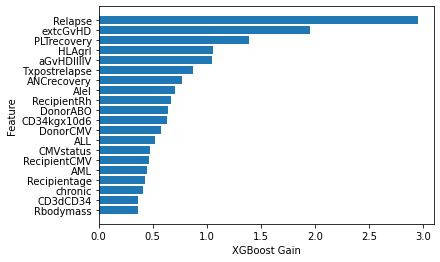

In [89]:
xgb_c.get_booster().feature_names = list(X.columns)
importance = xgb_c.get_booster().get_score(importance_type= 'gain')
for key in importance:
    importance[key] = [importance[key]]
imp_df = pd.DataFrame(importance).T.reset_index()
imp_df = imp_df.sort_values(0, ascending = False).head(n = 20)
plt.barh(imp_df['index'][::-1], imp_df[0][::-1])
plt.xlabel('XGBoost Gain')
plt.ylabel('Feature')

Interesting, like we initially saw in our exploratory correlation plot, we get the most accuracy gain from the *Relapse* feature, indicating whether or not an individual gets a hematological disease *again*. This makes sense, as a disease reoccuring might suggest something faulty with the immune system, or that the disease may have overcome some resistence and so it may be more lethal. The second most important predictor was the development of *Extensive Chronic Graft vs. Host Disease*. Graft vs. Host disease occurs when a body rejects the transplant and so could cause health complications downstream from transplant. Furthermore, the third most important predictor, *Time until platelet recovery* also resulted in a large gain of accuracy. This makes sense as platelets are an important part of the immune system and so a longer period of time until full recovery would increase the change of death.

# **Modeling Survival Time**

In [90]:
!pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
dat.columns

Index(['Recipientgender', 'Stemcellsource', 'Donorage', 'Donorage35', 'IIIV',
       'Gendermatch', 'DonorABO', 'RecipientABO', 'RecipientRh', 'ABOmatch',
       'CMVstatus', 'DonorCMV', 'RecipientCMV', 'Riskgroup', 'Txpostrelapse',
       'Diseasegroup', 'HLAmatch', 'HLAmismatch', 'Antigen', 'Alel', 'HLAgrI',
       'Recipientage', 'Recipientage10', 'Recipientageint', 'Relapse',
       'aGvHDIIIIV', 'extcGvHD', 'CD34kgx10d6', 'CD3dCD34', 'CD3dkgx10d8',
       'Rbodymass', 'ANCrecovery', 'PLTrecovery', 'time_to_aGvHD_III_IV',
       'survival_time', 'survival_status', 'ALL', 'AML', 'chronic', 'lymphoma',
       'nonmalignant'],
      dtype='object')

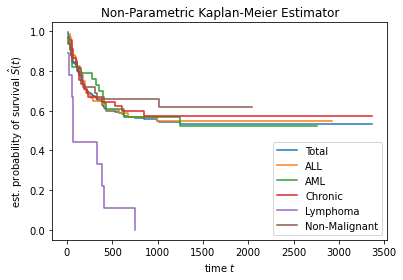

In [92]:
from sksurv.nonparametric import kaplan_meier_estimator

# disease idx
ALL_idx = dat.index[dat['ALL'] == 1].tolist()
AML_idx = dat.index[dat['AML'] == 1].tolist()
chronic_idx = dat.index[dat['chronic'] == 1].tolist()
lymphoma_idx = dat.index[dat['lymphoma'] == 1].tolist()
nonmalignant_idx = dat.index[dat['nonmalignant'] == 1].tolist()

time, survival_prob = kaplan_meier_estimator(Death.astype(bool), STime)
time_all, survival_prob_all = kaplan_meier_estimator(Death.astype(bool)[ALL_idx], STime[ALL_idx])
time_aml, survival_prob_aml = kaplan_meier_estimator(Death.astype(bool)[AML_idx], STime[AML_idx])
time_chr, survival_prob_chr = kaplan_meier_estimator(Death.astype(bool)[chronic_idx], STime[chronic_idx])
time_lym, survival_prob_lym = kaplan_meier_estimator(Death.astype(bool)[lymphoma_idx], STime[lymphoma_idx])
time_nm, survival_prob_nm = kaplan_meier_estimator(Death.astype(bool)[nonmalignant_idx], STime[nonmalignant_idx])
plt.step(time, survival_prob, where="post", label = 'Total')
plt.step(time_all, survival_prob_all, where="post", label = 'ALL')
plt.step(time_aml, survival_prob_aml, where="post", label = 'AML')
plt.step(time_chr, survival_prob_chr, where="post", label = 'Chronic')
plt.step(time_lym, survival_prob_lym, where="post", label = 'Lymphoma')
plt.step(time_nm, survival_prob_nm, where="post", label = 'Non-Malignant')
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title("Non-Parametric Kaplan-Meier Estimator")
plt.legend()

From the above Kaplan-Meier estimator, we see that individuals witih non-malignant hematological disease has the best survival. On the otherhand, all individuals with lymphoma (lymph node cancer) ended up in death and deviate from the proportional hazards assumption. The remaining conditions did not differ from the trend of the entire survival curve. Even so, we will attempt to model the survival time using a regularized Cox Proportional Hazards with elasticnet regularization, hopefully relaxing a little bit of this assumption.

### **Survival Analysis**

In [152]:
# https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html
import warnings
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline

# make [(outcome, time), ...] dataset
trainy_surv = np.array(list(zip(trainDeath_mp.astype(bool), trainSTime_mp)), 
                    dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, # elasticnet mixing (l1_ratio*l1 + (1-l1_ratio)*l2)
                           alpha_min_ratio=0.01, # min weighting of penalty
                           max_iter=100, # optimization
                           fit_baseline_model = True) # estimating baseline survival/cumhazard
)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(trainX_mp, trainy_surv) # searches for 100 alphas up to 1% of max

# choose best alpha from estimated 
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_ 
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, 
                                                           fit_baseline_model=True)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=5,
    error_score=0.5,
    n_jobs=1).fit(trainX_mp, trainy_surv)

cv_results = pd.DataFrame(gcv.cv_results_)

In [153]:
gcv.best_params_

{'coxnetsurvivalanalysis__alphas': [0.06523406814746949]}

In [154]:
best_params = {'coxnetsurvivalanalysis__alphas': [0.06523406814746949]}
cox = gcv.best_estimator_
#dat_orig = pd.read_csv('bone-marrow.csv')
#X_surv = trainX_mp.drop(['survival_status', 'survival_time'], axis = 1)

cox.fit(trainX_mp, trainy_surv)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[0.06523406814746949],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [155]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=0)
rsf.fit(trainX_mp, trainy_surv)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=0)

In [156]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.functions import StepFunction

testy_surv = np.array(list(zip(testDeath_mp.astype(bool), testSTime_mp)), 
                    dtype=[('Status', '?'), ('Survival_in_days', '<f8')])


score_cindex = pd.Series(
    [
        cox.score(testX_mp, testy_surv),
        rsf.score(testX_mp, testy_surv)
    ],
    index=["Cox", "RSF"], name="c-index",
)
score_cindex

Cox    0.689507
RSF    0.715203
Name: c-index, dtype: float64

In [163]:
testy_surv[0][0]

array([( True,  382.), (False, 1397.), (False, 1958.), ( True,   15.),
       (False, 1074.), (False, 3288.), ( True,  435.), ( True,  246.),
       (False, 2153.), (False, 2373.), (False, 1741.), (False, 2118.),
       ( True,  421.), (False,  676.), (False, 2926.), ( True,   58.),
       (False, 1308.), (False, 1985.), ( True, 1018.), (False,  884.),
       (False, 1781.), ( True,  236.), (False, 2800.), (False,  754.),
       (False, 2105.), (False, 1895.), (False,  676.), ( True,   48.),
       ( True,  182.), (False, 1692.), (False,  704.), ( True,   31.),
       ( True,  102.), ( True,  224.), ( True,  306.), ( True,  321.),
       ( True,   67.), (False, 2761.)],
      dtype=[('Status', '?'), ('Survival_in_days', '<f8')])

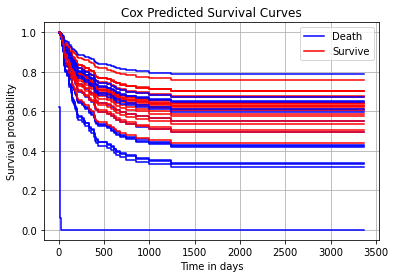

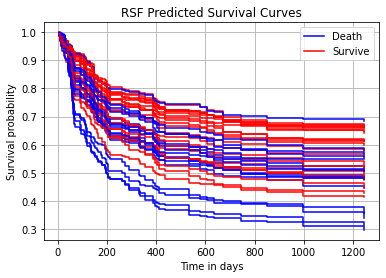

In [173]:
# predicted cox curves
surv_cox = cox.predict_survival_function(testX_mp, return_array=True)

a = 0
b = 0
for i, s in enumerate(surv_cox):
    if testy_surv[i][0]:
        c = 'blue'
        label = 'Death'
    else:
        c = 'red'
        label = 'Survive'
    plt.step(cox[1].event_times_, s, where="post", label=label, c = c)
    if label == 'Death':
        if b == 0:
            plt.legend()
            b += 1
    if label == 'Survive':
        if a == 0:
            plt.legend()
            a += 1
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.title("Cox Predicted Survival Curves")
plt.grid(True)
plt.show()

# predicted rsf curves
surv_rsf = rsf.predict_survival_function(testX_mp, return_array=True)
a, b = 0, 0
for i, s in enumerate(surv_rsf):
    if testy_surv[i][0]:
        c = 'blue'
        label = 'Death'
    else:
        c = 'red'
        label = 'Survive'
    plt.step(rsf.event_times_, s, where="post", label=label, c = c)
    if label == 'Death':
        if b == 0:
            plt.legend()
            b += 1
    if label == 'Survive':
        if a == 0:
            plt.legend()
            a += 1
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.title("RSF Predicted Survival Curves")
plt.grid(True)
plt.show()

The non-parametric random survival forest outperforms the Cox Proportional Hazards Regression model in terms of concordance index, a generalization of AUC for discriminative capability to determine which of a pair of individuals is at higher risk. By the curves you can see the tuned Cox model only models most of the curves well, but the rest are quickly being predicted to die.

Further hyperparameter tuning on both models could further improve performance, however I would still expect the random survival forest to outperform simple due to it's performance in literature.

# **Conclusions**

Altogether, these analyses show the effectiveness of non-parametric models in prediction tasks both at the classification and at the survival analysis level.